In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import csv
import glob
import os
from notify_run import Notify

In [29]:
#verry important
os.chdir(r"C:/Users/nieli/Documents/uva/thesis/code/")
print(os.getcwd())

notify = Notify()
results_folder = 'PPA/results/brouwer_vandenberg_2022/results-2021-09-16_12-55-16'

# change the plot colors and layout
sns.set_theme(style="whitegrid")

switched_colors = sns.color_palette("deep")
# switched_colors[2] = switched_colors[6]
# switched_colors[6] = sns.color_palette("deep")[2]
sns.set_palette(switched_colors)

C:\Users\nieli\Documents\uva\thesis\code


In [3]:
n_dimensional_benchmark = ['Ackley', 'Rosenbrock', 'Griewank', 'Rastrigrin', 'Schwefel', 'Ellipse', 'Cigar', 'Tablet', 'Sphere']
renames = {
    'mupluslambda':'PS',
    'mulambda':'CS',
    'tournament':'TS+R', 
    'roulette_wheel':'RWS',
    'linear_ranking':'LRS',
    'single_elitist_rws':'ERWS',
    'single_elitist_tournament':'ETS',
    'no_replacement_tournament':'TS-R'
}


## We load the necessary data

In [4]:
# Load all the best-so-far performances to select the median runs
best_so_far_files = glob.glob(results_folder + "/*_performance.csv")
li = []

for filename in best_so_far_files:
    
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame['error'] = abs(frame['optimum'] - frame['best_during run'])
frame['selection_name'] = frame['selection_method'].apply(lambda x: renames[x])  


In [5]:
# we export the median_df of the plus selection (mupluslambda: default ppa selection) to another CSV file to compare it with the results of Vrielink and van den Berg 2021
frame[frame['selection_method'] == 'mupluslambda'][['benchmark_name','dimensions','best_during run','run_n']].to_csv('PPA/results/my_results_rep/my_results.csv', index=False)

this should be the total number of benchmark function instances per run: 59


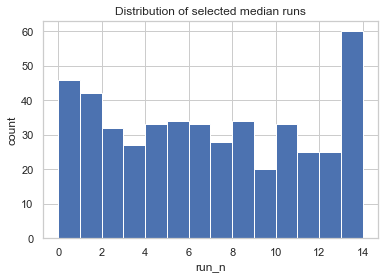

In [6]:
median_df = pd.DataFrame()

# group the data by selection method, benchmark_name, and dimensions and extract the run with the median performance
# if there exist multiple runs with the same performance, select the first
grouped = frame.groupby(['selection_method','benchmark_name','dimensions']).median().reset_index()

for i,row in grouped.iterrows():
    median_df = median_df.append(frame[
        (frame['selection_method'] == row['selection_method']) & 
        (frame['benchmark_name'] == row['benchmark_name']) & 
        (frame['dimensions'] == row['dimensions']) &
        (frame['error'] == row['error'])
    ].iloc[0])
    
#use this to check if all selection methods for all benchmark functions per dimension is present, should be 59:
print("this should be the total number of benchmark function instances per run: "+ str(len(median_df.groupby(['benchmark_name','dimensions']).count())))

# check the distribution of the selected run numbers
plt.hist(median_df.run_n, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

plt.xlabel('run_n')
plt.ylabel('count')
plt.title('Distribution of selected median runs')
plt.show()

In [7]:
# Load the detailed data of the median runs, containing the performance per generation
# p_df = performance data frame
# u_df = unique individuals data frame
performance_details = glob.glob(results_folder + "/*_performance_over_generations.csv")
li = []

for i,row in median_df.iterrows():
    if row['benchmark_name'] in n_dimensional_benchmark:
        performance_filename = row['selection_method']+"-"+row['benchmark_name']+str(int(row['dimensions']))+"Drun-"+str(int(row['run_n']))+"_performance_over_generations.csv"
        unique_filename = row['selection_method']+"-"+row['benchmark_name']+str(int(row['dimensions']))+"Drun-"+str(int(row['run_n']))+"_unique_individuals.csv"
        
    if row['benchmark_name'] not in n_dimensional_benchmark:
        performance_filename = row['selection_method']+"-"+row['benchmark_name']+"run-"+str(int(row['run_n']))+"_performance_over_generations.csv"
        unique_filename = row['selection_method']+"-"+row['benchmark_name']+"run-"+str(int(row['run_n']))+"_unique_individuals.csv"
        
        
    p_df = pd.read_csv(results_folder+"/"+performance_filename, index_col=None, header=0)
    u_df = pd.read_csv(results_folder+"/"+unique_filename, index_col=None, header=0)
    
    
    p_df['selection_method'] = row['selection_method']
    p_df['selection_name'] = p_df['selection_method'].apply(lambda x: renames[x])  
    p_df['benchmark_name'] = row['benchmark_name']
    p_df['dimensions'] = int(row['dimensions'])
    p_df['error'] = abs(row['optimum'] - p_df['objective_value'])
    p_df['run_name'] = row['selection_method'] + "-" + row['benchmark_name'] + "-" + str(int(row['dimensions']))
    p_df = pd.merge(p_df, u_df, on=['generation'])
    
    li.append(p_df)   

performances = pd.concat(li, axis=0, ignore_index=True)

### We create heatmaps to compare magnitudes of differences

C:\Users\nieli\miniconda3\envs\ppa_data_vis\lib\site-packages\ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


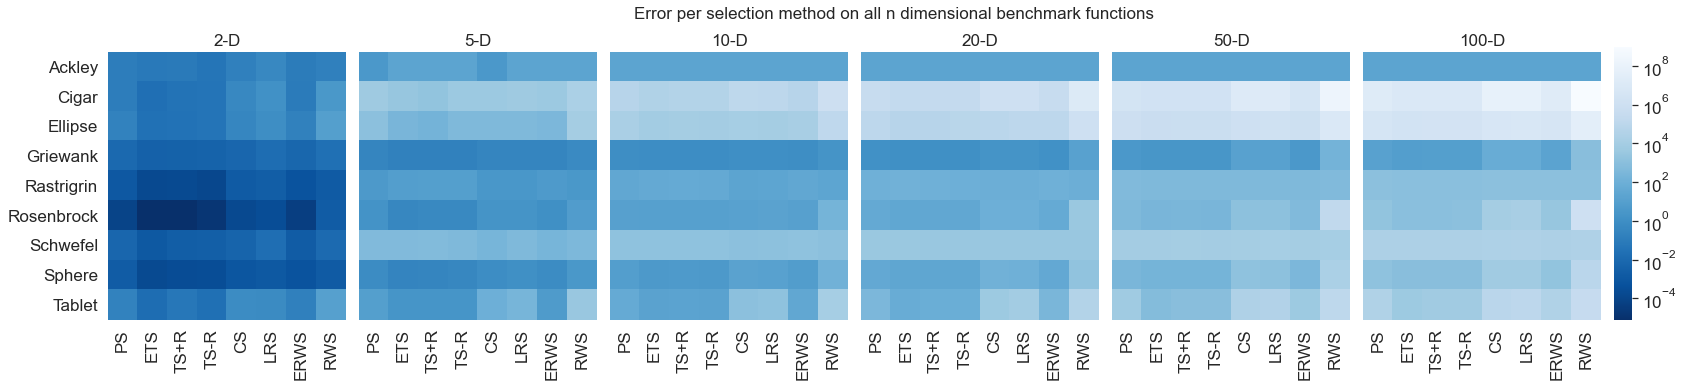

In [8]:
# only select the ndimensional benchmark functions and their dimensions
nd_final_performance = median_df[median_df['benchmark_name'].isin(n_dimensional_benchmark)]
dimensions = nd_final_performance.dimensions.unique()

# create a heatmap for each dimension for the ndimensional benchmark functions
fig, axs = plt.subplots(nrows=1,ncols=len(dimensions), figsize=(25,5.5))

# color pallete for the heatmap and define order of display for selection methods
heatmap_colors = sns.color_palette("Blues_r", as_cmap=True)
heatmap_column_order = ['mupluslambda','single_elitist_tournament','tournament','no_replacement_tournament','mulambda','linear_ranking','single_elitist_rws','roulette_wheel']


# pre determine what the minimum and maximum heatmap values are so the colour scale is equal for the heatmaps per dimension:
min_error = nd_final_performance.error.min()
max_error = nd_final_performance.error.max()

# start the counter at -1 so the first plot is placed at position 0
counter = -1

# plot for each dimension a seperate heatmap, only the first heatmap has y labels, and only the last has the colorbar
for dim in dimensions:
    counter +=1
    data = nd_final_performance[nd_final_performance.dimensions == dim][['selection_name','benchmark_name','error']]
    plot_data = data.pivot(index='benchmark_name', columns='selection_name', values='error')
    plot_data = plot_data[[renames[x] for x in heatmap_column_order]]
    
    if dim == 2:
        ax = sns.heatmap(plot_data, ax=axs[counter], norm=LogNorm(vmin=min_error, vmax=max_error), cmap=heatmap_colors, cbar=False, square=True)
    elif dim == 100:
        cbar_ax = fig.add_axes([.90, .19, .01, 0.69]) #[Horizontal coordinate of the lower left corner,  Vertical coordinate of the lower left corner, Width of the subplot,  Height of the subplot]
        
        ax = sns.heatmap(plot_data, ax=axs[counter], norm=LogNorm(vmin=min_error, vmax=max_error), cmap=heatmap_colors, square=True, cbar_ax=cbar_ax)#norm=LogNorm(vmin=min_error, vmax=max_error); midpoint=1
        ax.set(yticklabels=[])
        ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)
        ax.collections[0].colorbar.ax.tick_params(labelsize=17)
        
    else:
        ax = sns.heatmap(plot_data, ax=axs[counter], norm=LogNorm(vmin=min_error, vmax=max_error), cmap=heatmap_colors, cbar=False, square=True) #norm=LogNorm(vmin=min_error, vmax=max_error)
        ax.set(yticklabels=[])
    ax.set_title(f'{int(dim)}-D', fontsize=17)
    ax.set_ylabel('') 
    ax.set_xlabel('')
    ax.tick_params(labelsize=17)
    
fig.tight_layout(rect=[0, 0, .9, 1])
fig.suptitle("Error per selection method on all n dimensional benchmark functions", fontsize=17)
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/nd_heatmap.eps', bbox_inches='tight', format='eps', dpi=1200)

plt.show()

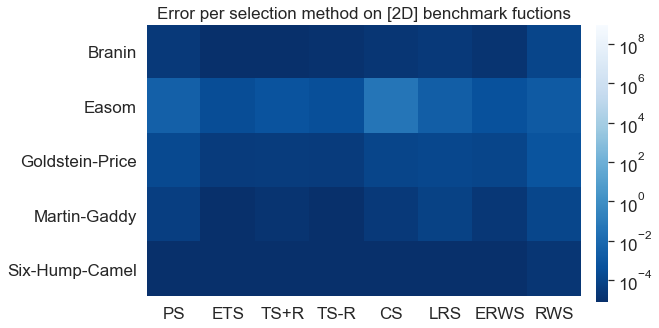

In [9]:
# NOTE: first the previous heatmaps need to be created in order to create this one
# plot the heatmap for the benchmark functions solely present in 2 dimensions
two_d_data = median_df[~median_df['benchmark_name'].isin(n_dimensional_benchmark)].pivot(index='benchmark_name', columns='selection_name', values='error')
two_d_data = two_d_data[[renames[x] for x in heatmap_column_order]]

fig, axs = plt.subplots(ncols=1, figsize=(10,5))
cbar_ax = fig.add_axes([0.835, .11, .017, 0.77]) #[Horizontal coordinate of the lower left corner,  Vertical coordinate of the lower left corner, Width of the subplot,  Height of the subplot]
ax = sns.heatmap(two_d_data, ax=axs, norm=LogNorm(vmin=min_error, vmax=max_error), cmap=heatmap_colors, square=True, cbar_ax=cbar_ax)
ax.collections[0].colorbar.ax.tick_params(labelsize=14)
ax.set_ylabel('')
ax.set_xlabel('')
ax.tick_params(labelsize=17)
ax.collections[0].colorbar.ax.tick_params(labelsize=17)
ax.set_title('Error per selection method on [2D] benchmark fuctions',fontsize=17)
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/2d_heatmap.eps', bbox_inches='tight', format='eps', dpi=1200)
plt.show()

### We look at how the selection methods compare to eachother

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

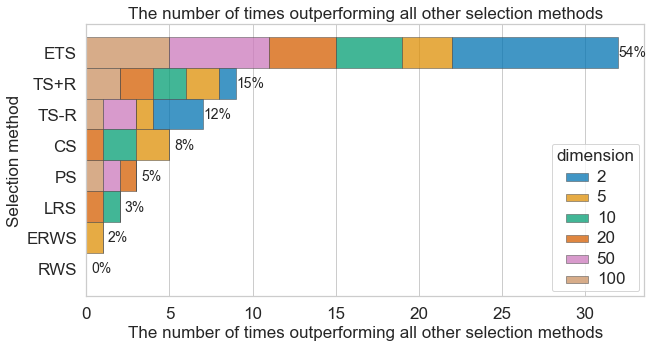

In [10]:
# loop through all data and see how many per selection method per benchmark function for every dimension a selection method has the lowest error
plt.figure(figsize=(10, 5))
data = median_df
count_df = pd.DataFrame(columns=['selection_method','dimension','counter'])

# we add an entry to count_df for every time a selection method "won" on a benchmark function instance
for benchmark in data.benchmark_name.unique():
    for dimension in data[data.benchmark_name == benchmark].dimensions.unique():
        benchmark_dim_data = data[(data.benchmark_name == benchmark) & (data.dimensions == dimension)]
        min_id = benchmark_dim_data.error.argmin()
        count_df = count_df.append({"selection_method":benchmark_dim_data.iloc[min_id].selection_method,"dimension":int(dimension),"counter":1}, ignore_index=True)

# little "hack" to include the selection methods that never won, not the counter=0
for selection_method in data.selection_method.unique():
    count_df = count_df.append({"selection_method":selection_method,"dimension":int(2),"counter":0}, ignore_index=True)
        
# now we sum the number of times a selection method won per dimension
count_df = count_df.groupby(['selection_method','dimension']).sum().sort_values(by=['counter','dimension'],ascending=False)
count_df = count_df.reset_index()

# sum by selection method for the text at the end of a bar applied later, and the order of the bars from high to low
summed_by_selection_method = count_df.groupby('selection_method').sum().sort_values(by=['counter'],ascending=False).reset_index()

# make a column that handles the order based on the grouped (by selection method only) sum
i = 0
for name in summed_by_selection_method.selection_method:
    count_df.loc[count_df.selection_method == name,'order'] = i
    i+=1
count_df = count_df.sort_values(by='order')
    
# plot the data
count_df['selection_method'] = [renames[x] for x in count_df['selection_method']]
g = sns.histplot(count_df,y='selection_method', weights='counter',multiple="stack",hue='dimension',palette="colorblind", edgecolor=".3", linewidth=0.5)

# we add percentages at the end of each stacked bar
i = 0
for index,row in count_df.groupby('selection_method').sum().sort_values(by=['counter'],ascending=False).iterrows():
    g.text(row.counter+0.9, abs(0-i), f'{round((row.counter/59)*100)}%', horizontalalignment='center', verticalalignment='center', fontsize=14)
    i+=1

# some plot formatting:
fontsize = 17
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.setp(g.get_legend().get_texts(), fontsize='17') # for legend text
plt.setp(g.get_legend().get_title(), fontsize='17') # for legend title

# plt.grid()
g.grid(axis='y')
plt.title('The number of times outperforming all other selection methods', fontsize=fontsize)
plt.ylabel('Selection method', fontsize=fontsize)
plt.xlabel('The number of times outperforming all other selection methods', fontsize=fontsize)
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/outperforming_all.eps', bbox_inches='tight', format='eps', dpi=1200)

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

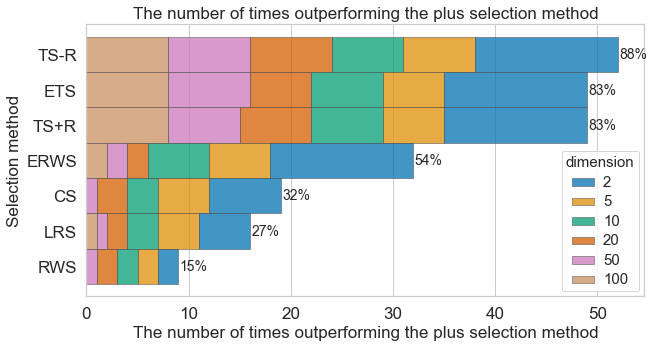

In [11]:
# we now compare how well each selection method performs in comparison to the default selection method of the PPA, Plus Selection (PS) or mupluslambda
plt.figure(figsize=(10, 5))
data = median_df
outperforms_df = pd.DataFrame(columns=['selection_method','dimension','counter'])

# we loop thourgh the benchmark function instances and compare the error of ps with the error of every selection method for the same benchmark function instance
for benchmark in data.benchmark_name.unique():
    
    for dim in data[data.benchmark_name == benchmark].dimensions.unique():
        ps_error = data[(data['selection_method']=='mupluslambda') & (data['benchmark_name']==benchmark) & (data['dimensions']==dim)]['error']
        
        for method in data.selection_method.unique():

            selection_method_error = data[(data['selection_method']==method) & (data['benchmark_name']==benchmark) & (data['dimensions']==dim)]['error']
            if float(ps_error) > float(selection_method_error):
                outperforms_df= outperforms_df.append({"selection_method":method,"dimension":int(dim),"counter":1}, ignore_index=True)
                

# we group the data per selection method, per dimension (to create the seperate bins)                
outperforms_df = outperforms_df.groupby(['selection_method','dimension']).sum().sort_values(by=['counter'],ascending=False)

#we sort the data by the selection method with the highest number of times outperforming the ps selection method
outperforms_df = outperforms_df.loc[(outperforms_df.groupby('selection_method').sum().sort_values('counter', ascending=False).index.values)].reset_index()

# plot the data in a stacked bar chart
outperforms_df['selection_method'] = [renames[x] for x in outperforms_df['selection_method']]
g = sns.histplot(outperforms_df,y='selection_method', weights='counter',multiple="stack",hue='dimension',palette="colorblind", edgecolor=".3", linewidth=0.5)

# add labels at the end of the barchart
i = 0
for index,row in outperforms_df.groupby('selection_method').sum().sort_values(by=['counter'],ascending=False).iterrows():
    g.text(row.counter+1.5, abs(0-i), f'{round((row.counter/59)*100)}%', horizontalalignment='center', verticalalignment='center', fontsize=14)
#     g.text(row.counter+1.5, abs(0-i), r'$\dfrac{%d}{59}$'%(row.counter), horizontalalignment='center', verticalalignment='center', fontsize=15)
    i+=1
    
# formatting of the plot    
fontsize = 17
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)    
plt.setp(g.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(g.get_legend().get_title(), fontsize='15') # for legend title


g.grid(axis='x')
plt.title('The number of times outperforming the plus selection method', fontsize=fontsize)
plt.ylabel('Selection method', fontsize=fontsize)
plt.xlabel('The number of times outperforming the plus selection method',fontsize=fontsize)
plt.grid()
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/outperforming_ps.eps', bbox_inches='tight', format='eps', dpi=1200)


plt.show()

### We now create the plots containing error, median fitness, and number of distinct individuals per generation

In [12]:
# first we define the benchmark instance of interest 
benchmark_name = "Rosenbrock"
dimensions = 100
performance_df = performances[(performances['benchmark_name'] == benchmark_name) & (performances['dimensions'] == dimensions)]

performance_df.head(2)

,objective_value,generation,evaluations,selection_method,selection_name,benchmark_name,dimensions,error,run_name,unique_ids
27414,9.294497e+06,0,30,linear_ranking,LRS,Rosenbrock,100,9.294497e+06,linear_ranking-Rosenbrock-100,30
27415,9.187349e+06,1,98,linear_ranking,LRS,Rosenbrock,100,9.187349e+06,linear_ranking-Rosenbrock-100,21


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


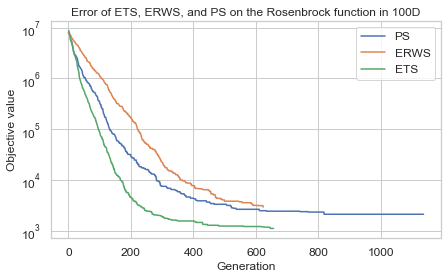

In [31]:
# we plot the error per generation for selected "selection methods"
fig,ax = plt.subplots(figsize=(7,4))
benchmark_name = "Rosenbrock"
dimensions = 100
# we place the selection methods under comparison in a list for later use
selection_methods = ['mupluslambda','single_elitist_rws','single_elitist_tournament']

ets_data = performance_df[performance_df['selection_method'] == 'single_elitist_tournament'] #elitist tournament selection data
erws_data = performance_df[performance_df['selection_method'] == 'single_elitist_rws'] #elitist rws data
ps_data = performance_df[performance_df['selection_method'] == 'mupluslambda'] #plus selection data

sns.lineplot(x=ps_data.generation, y=ps_data.error, label=renames['mupluslambda'])
sns.lineplot(x=erws_data.generation, y=erws_data.error, label=renames['single_elitist_rws'])
sns.lineplot(x=ets_data.generation, y=ets_data.error, label=renames['single_elitist_tournament'])

# plot formatting
plt.title(f'Error of {renames["single_elitist_tournament"]}, {renames["single_elitist_rws"]}, and {renames["mupluslambda"]} on the {benchmark_name} function in {dimensions}D', fontsize=12)
plt.ylabel('Objective value', fontsize=12)
plt.xlabel('Generation', fontsize=12)
plt.yscale("log")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=12)
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/error_value_ETS_PS_ERWS_Rosenbrock.eps', bbox_inches='tight', format='eps', dpi=1200)


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


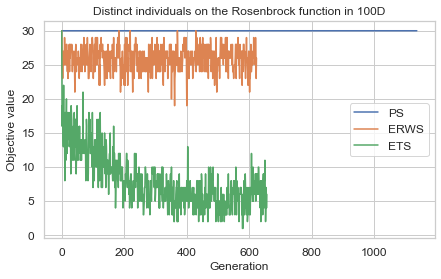

In [32]:
# plot the nubmer of distinct individuals using the variables set in the previous cell
fig,ax = plt.subplots(figsize=(7,4))
benchmark_name = "Rosenbrock"
dimensions = 100
sns.lineplot(x=ps_data.generation, y=ps_data.unique_ids, label=renames['mupluslambda'])
sns.lineplot(x=erws_data.generation, y=erws_data.unique_ids, label=renames['single_elitist_rws'])
sns.lineplot(x=ets_data.generation, y=ets_data.unique_ids, label=renames['single_elitist_tournament'])


# plot formatting
plt.title(f'Distinct individuals on the {benchmark_name} function in {dimensions}D', fontsize=12)
plt.ylabel('Objective value', fontsize=12)
plt.xlabel('Generation', fontsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=12, loc="center right")
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/distinct_ETS_PS_ERWS_Rosenbrock.eps', bbox_inches='tight', format='eps', dpi=1200)

plt.show()

### Here we load all the fitness data, which takes increadibly long since i saved it as a csv containing dicts instead of lists.....

In [15]:
# # # create a data frame to store all fitness and rank information per individual over the generations
# # fitness_df = pd.DataFrame(columns=['id','selection_method','rank','fitness','generation'])
# fitness_df = pd.DataFrame()
# for selection_method in selection_methods:
#     for benchmark_name in median_df.benchmark_name.unique():
#         for dimensions in median_df[median_df['benchmark_name'] == benchmark_name].dimensions.unique():
#             run_n = median_df[
#                 (median_df['selection_method'] == selection_method) &
#                 (median_df['benchmark_name'] == benchmark_name) &
#                 (median_df['dimensions'] == dimensions)
#             ].run_n

#             #load the fitness data for the benchmark instance and selection method
#             if benchmark_name in n_dimensional_benchmark:
#                 fitness_filename = selection_method+"-"+benchmark_name+str(int(dimensions))+"Drun-"+str(int(run_n))+"_fitness_ranks.csv"
#             else:
#                 fitness_filename = selection_method+"-"+benchmark_name+"run-"+str(int(run_n))+"_fitness_ranks.csv"


#             with open(results_folder+"/"+fitness_filename) as file:
#                 reader = csv.DictReader(file)
#                 for row in reader:
#                     to_list = list(row.items())

#                     list_data = [eval(str.replace(item,'"','')) for item in to_list[1][1]]
#                     list_data.append(eval(str.replace(to_list[0][1],'"','')))

#                     temp_df = pd.DataFrame(list_data)
#                     temp_df['selection_method'] = selection_method
#                     temp_df['benchmark'] = benchmark_name
#                     temp_df['dimensions'] = dimensions
#                     fitness_df = fitness_df.append(temp_df, ignore_index=True)


#### Export it so we don't have to loop through and eval again

In [16]:
# fitness_df.to_csv(results_folder+"/ets_erws_ps-fitness_ranks/ets_erws_ps-fitness_ranks-all.csv")

In [17]:
fitness_df = pd.read_csv(results_folder+"/ets_erws_ps-fitness_ranks/ets_erws_ps-fitness_ranks-all.csv", index_col=0)
fitness_df = fitness_df.reset_index(drop=True)

C:\Users\nieli\miniconda3\envs\ppa_data_vis\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Lets plot the median fitness!

In [26]:
fitness_df[(fitness_df['selection_method'] == selection_method)&(fitness_df['benchmark'] == benchmark_name) & (fitness_df['dimensions'] == dimensions)]

,id,rank,fitness,generation,selection_method,benchmark,dimensions
3548520,18,2,0.836448,0,mupluslambda,Rosenbrock,100.0
3548521,11,3,0.795596,0,mupluslambda,Rosenbrock,100.0
3548522,2,4,0.788276,0,mupluslambda,Rosenbrock,100.0
3548523,13,5,0.726349,0,mupluslambda,Rosenbrock,100.0
3548524,4,6,0.684112,0,mupluslambda,Rosenbrock,100.0
...,...,...,...,...,...,...,...
3582625,41418,27,0.037038,1136,mupluslambda,Rosenbrock,100.0
3582626,44298,28,0.033001,1136,mupluslambda,Rosenbrock,100.0
3582627,42532,29,0.026101,1136,mupluslambda,Rosenbrock,100.0
3582628,47107,30,0.017986,1136,mupluslambda,Rosenbrock,100.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

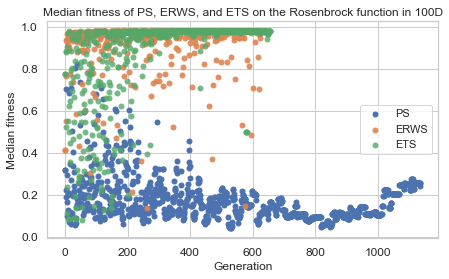

In [33]:
fix, ax = plt.subplots(figsize=(7, 4))
benchmark_name = "Rosenbrock"
dimensions = 100
# show the median fitness per generation for the selection methods
i = 0
for selection_method in selection_methods:
    
    plot_data = fitness_df[(fitness_df['selection_method'] == selection_method)&(fitness_df['benchmark'] == benchmark_name) & (fitness_df['dimensions'] == dimensions)].groupby('generation').median()
    sns.scatterplot(x='generation', y='fitness',data=plot_data, label=renames[selection_method], alpha=1-(i/10), linewidth=0)
    i+=1

# plot formatting
plt.title(f'Median fitness of {renames[selection_methods[0]]}, {renames[selection_methods[1]]}, and {renames[selection_methods[2]]} on the {benchmark_name} function in {dimensions}D')
ax.legend(loc="center right")
# plt.legend(loc="upper right", bbox_to_anchor=(0.9,0.99)) #position of legend for the slides
plt.ylabel('Median fitness', fontsize=12)
plt.xlabel('Generation', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/fitness_ETS_PS_ERWS_Rosenbrock.eps', bbox_inches='tight', format='eps', dpi=1200)
plt.show()

### Manually check if the shapes of all the benchmark function plots are similar

In [ ]:
for benchmark in performances.benchmark_name.unique():
    selection_benchmark_data = performances[performances['benchmark_name'] == benchmark_name]
    for dim in selection_benchmark_data.dimensions.unique():
        data = benchmark_data[benchmark_data['dimensions'] == dim]
        sns.lineplot(x=data[data['selection_method'] == 'single_elitist_tournament'].generation, y=data[data['selection_method'] == 'single_elitist_tournament'].unique_ids, label=renames['single_elitist_tournament'])
        sns.lineplot(x=data[data['selection_method'] == 'single_elitist_rws'].generation, y=data[data['selection_method'] == 'single_elitist_rws'].unique_ids, label=renames['single_elitist_rws'])
        sns.lineplot(x=data[data['selection_method'] == 'mupluslambda'].generation, y=data[data['selection_method'] == 'mupluslambda'].unique_ids, label=renames['mupluslambda'])
        plt.show()

In [ ]:
for benchmark in fitness_df.benchmark.unique():
    benchmark_fdf = fitness_df[fitness_df['benchmark'] == "Rosenbrock"]
    for dim in benchmark_fdf.dimensions.unique():
        data = benchmark_fdf[benchmark_fdf['dimensions'] == dim]
        for selection_method in data.selection_method.unique():
            plot_data = data[data['selection_method'] == selection_method].groupby('generation').median()
            sns.scatterplot(x='generation', y='fitness',data=plot_data, label=renames[selection_method], alpha=1-(i/10), linewidth=0)
        plt.show()